## MIDS267 - Week 6 - Lesson Notebook Three: Stable Diffusion Pipeline Model


In [the previous notebook]() we used a simple [Diffusion Model](https://arxiv.org/pdf/2103.00020.pdf) to demonsrate how the denoising process can result in novel outputs.  This notebook looks at the more complex Stable Diffusion Pipeline used in such commercial applications as DALL-E, Mid Journey, and Stable DIffusion.  We leverage the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/en/index) classes. This notebook is based on their [Stable Diffusion notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).




The stable diffusion pipeline allows a user to enter a text prompt which is fed through a CLIP text encoder.  The resulting encoding is now fed to the prior image reconstruction model that is trained to take the CLIP text embeddings and predict a corresponding CLIP image encoding.  That image vector is now fed, as conditioning into the decoder which includes several diffusion models.  These diffusion models perform specific tasks, either manipulating the image vector in latent space or upscaling the emerging image to produce the high resolution output.  This notebook shows all of the pieces in the pipeline using the diffusers classes.

This notebook requires a GPU to run.


### Setup

In [1]:
%%capture

!pip install -q diffusers
!pip install -q transformers scipy ftfy accelerate

In [2]:
#prefer running this on a GPU
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from PIL import Image

Stable Diffusion is a pipeline that allows the user to have some control over image generation via a text prompt.  In order to accomplish this a number of different models have to be used beyond the UNet and the Scheduler that we saw in the simple diffusion network.

This pipeline is proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

To convert our text input into text embeddings we will use CLIP which is limited to 77 input tokens.

Since what we really want is an image to feed the model, we'll use a UNet_model to convert the CLIP text representation into a CLIP image representation.  It won't be perfect but it will be close enough to give us an image similar to what the user requests in their prompt.  

Then we have a decoder that can take a small modified image and convert it into a much larger (upsampled) image.

We're using the stable-diffusion-v1-4 checkpoint which incorporates a number of components.

In [4]:
%%capture

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler


# 1. Load the tokenizer and text encoder to tokenize and encode the text using CLIP.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 2. The UNet model for generating the latents.  This is the image encoding equivalent to the CLIP text embedding.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# 3. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")


As before, we will also need a scheduler

In [5]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

We want to run on a GPU so let's push our various components there.

In [6]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Enter your text prompt for image generation here.  Feel free to experiment to see how your words get interpreted as an image.

In [7]:
prompt = ["a photograph of a data scientist riding an ostrich"]

Here are some configuration hyperparameters you can specify.  The  `guidance_scale` hyperparameter is a way to increase the adherence to the conditional signal (text prompt) as well as overall sample quality. Numbers like `7` or `8.5` give good results. Very large numbers mean the images might look good, but will be less diverse.

In [8]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance (see https://arxiv.org/pdf/2205.11487.pdf for details)

generator = torch.manual_seed(32)   # Seed generator to create the initial latent noise

batch_size = 1

Get the CLIP text embeddings from the prompt.

In [9]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [10]:
text_embeddings.shape

torch.Size([1, 77, 768])

In [11]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [12]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the random noise and check the shape.

In [13]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-13-132bcdf2870d>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [14]:
latents.shape

torch.Size([1, 4, 64, 64])

Initialize the scheduler to the number of steps we want to take to complete the denoising.

In [15]:
scheduler.set_timesteps(num_inference_steps)

Our scheduler needs to compute the sigmas and the exact time step values for the denoising.

In [16]:
latents = latents * scheduler.init_noise_sigma

We need our denoising loop to proceed through timesteps iterations gradually adding and removing noise from the image.  We print the interim image so you can see the shapes emerge as you get to the final timestep of the noising/denoising loop.

  0%|          | 0/100 [00:00<?, ?it/s]

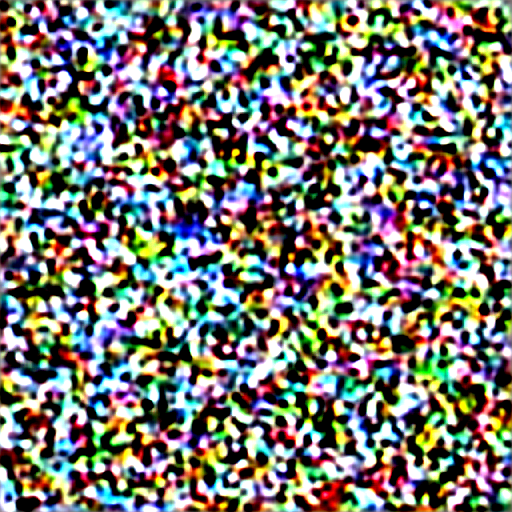

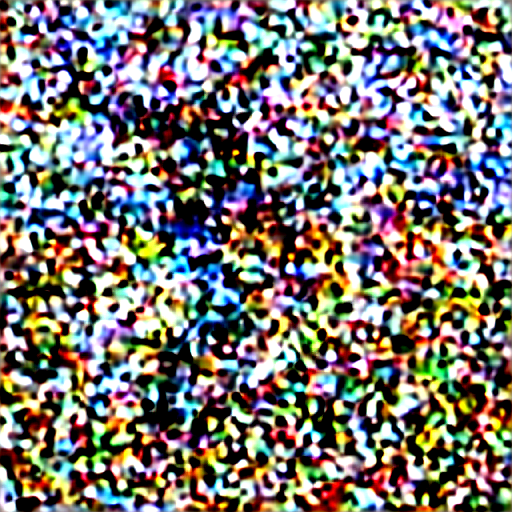

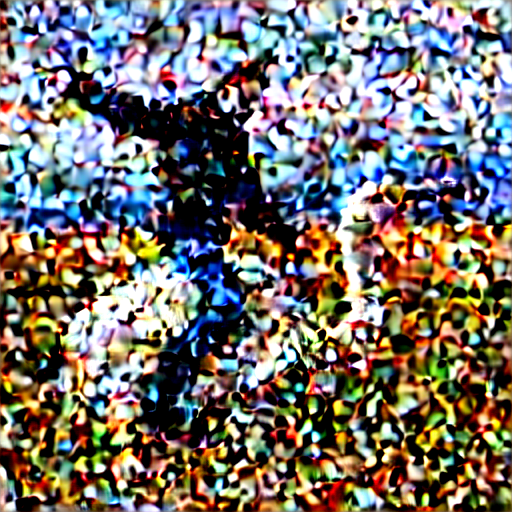

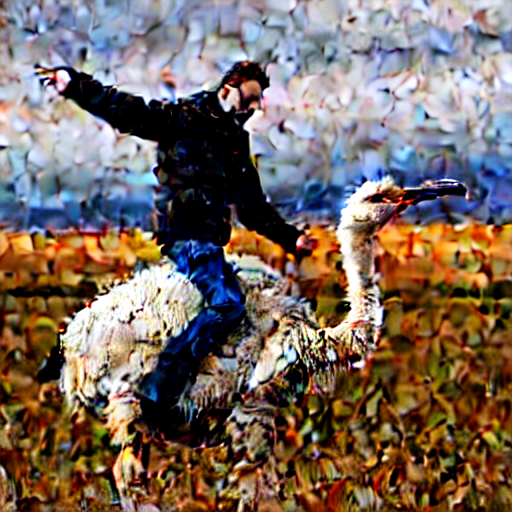

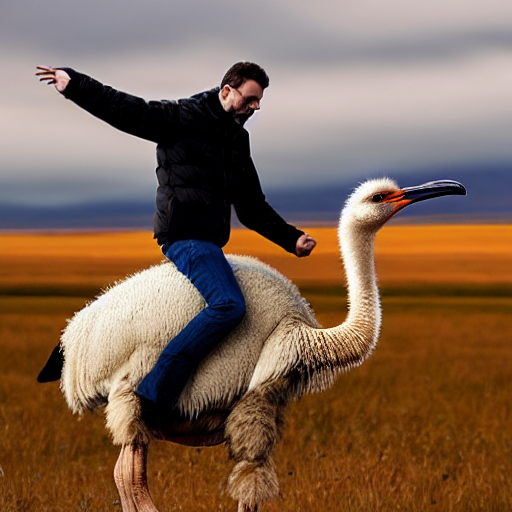

In [17]:
from tqdm.auto import tqdm
from torch import autocast

in_between_images = [0, 24, 49, 74, 99]

for step, t in enumerate(tqdm(scheduler.timesteps)):

  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes. See https://arxiv.org/pdf/2205.11487.pdf
  latent_model_input = torch.cat([latents] * 2)


  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual for this timestep
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  if step in in_between_images:

    # scale and decode the image latents with vae
    new_latents = 1 / 0.18215 * latents

    with torch.no_grad():
      image = vae.decode(new_latents).sample

    # show image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(pil_images[0])
    print()


